# Tutorial 2: mouse olfactory bulb generated by Stereo-seq

This tutorial demonstrates the analysis of spatial transcriptomics data from the mouse olfactory bulb, generated using Stereo-seq technology. The dataset is publicly available through [Zenodo](https://doi.org/10.5281/zenodo.8356092).  

For quality control purposes, we preprocessed the data by filtering out spots located outside the main tissue region following the STAGATE method[1]. The curated dataset containing only the valid tissue spots can be accessed via [shared Google Drive repository](https://drive.google.com/drive/folders/10lhz5VY7YfvHrtV40MwaqLmWz56U9eBP?usp=sharing). 

---  

## Loading and Preparing Data

In [1]:
import pandas as pd  
import numpy as np  
import scanpy as sc  
import anndata as ad  
import matplotlib.pyplot as plt  
from sklearn.metrics import adjusted_rand_score  
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi  
from SEPAR_model import SEPAR  

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import os
filepath = '/Users/zhang/globus/Dataset1_LiuLongQi_MouseOlfactoryBulb'
counts_file = os.path.join(filepath, 'RNAcounts.h5ad')
coor_file = os.path.join(filepath, 'position.tsv')
# Load spatial coordinates  
coor_df = pd.read_csv(coor_file, sep='\t')  
coor_df.index = coor_df.index.map(lambda x: 'Spot_'+str(x+1))  
coor_df = coor_df.loc[:, ['x','y']]  

# Read count data  
adata = sc.read_h5ad(filename=counts_file)  
adata.var_names_make_unique()  

# Add spatial coordinates  
adata.obsm["spatial"] = coor_df.to_numpy()[:,[1,0]]  

# Quality control  
sc.pp.calculate_qc_metrics(adata, inplace=True)  

used_barcode = pd.read_csv('/Users/zhang/globus/Dataset1_LiuLongQi_MouseOlfactoryBulb/used_barcodes.txt',sep='\t', header=None)
used_barcode = used_barcode[0]
adata = adata[used_barcode,]
# Initialize SEPAR  
separ = SEPAR(adata, n_cluster=8)  

## Data Preprocessing

After filtering:  (19109, 14376)


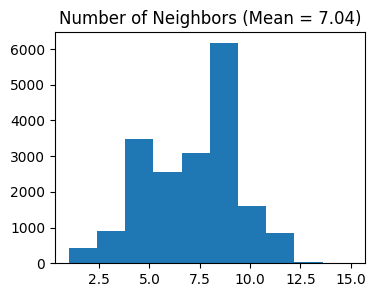

Counting moran's i ...

Finish selecting


In [3]:
# Preprocess the data  
separ.preprocess(min_cells=50)  

# Compute spatial graph  
separ.compute_graph()  

# Select features using Moran's I  
separ.select_morani(nslt=2000)  

# Compute weights  
separ.compute_weight(n_cluster=10)  

## 1. Running SEPAR Algorithm

In [4]:
# Run SEPAR algorithm  
separ.separ_algorithm(  
    r=30,              # Number of spatial patterns  
    alpha=0.8,         # Graph regularization weight  
    beta=0.05,         # Sparsity penalty weight (previously l1)  
    gamma=0.5          # Pattern orthogonality weight (previously lam)  
)

Processing iterations: 100%|██████████| 100/100 [02:11<00:00,  1.32s/it]


## 2. Identifying Pattern-Specific Genes

In [5]:
# Identify pattern-specific genes  
pattern_genes = separ.identify_pattern_specific_genes(  
    n_patterns=30,    # Number of patterns to consider  
    threshold=0.3     # Threshold for gene-pattern association  
)  

### Pattern Visualization and Pattern-specific Genes

First, let's visualize the identified spatial patterns and analyze their characteristics:

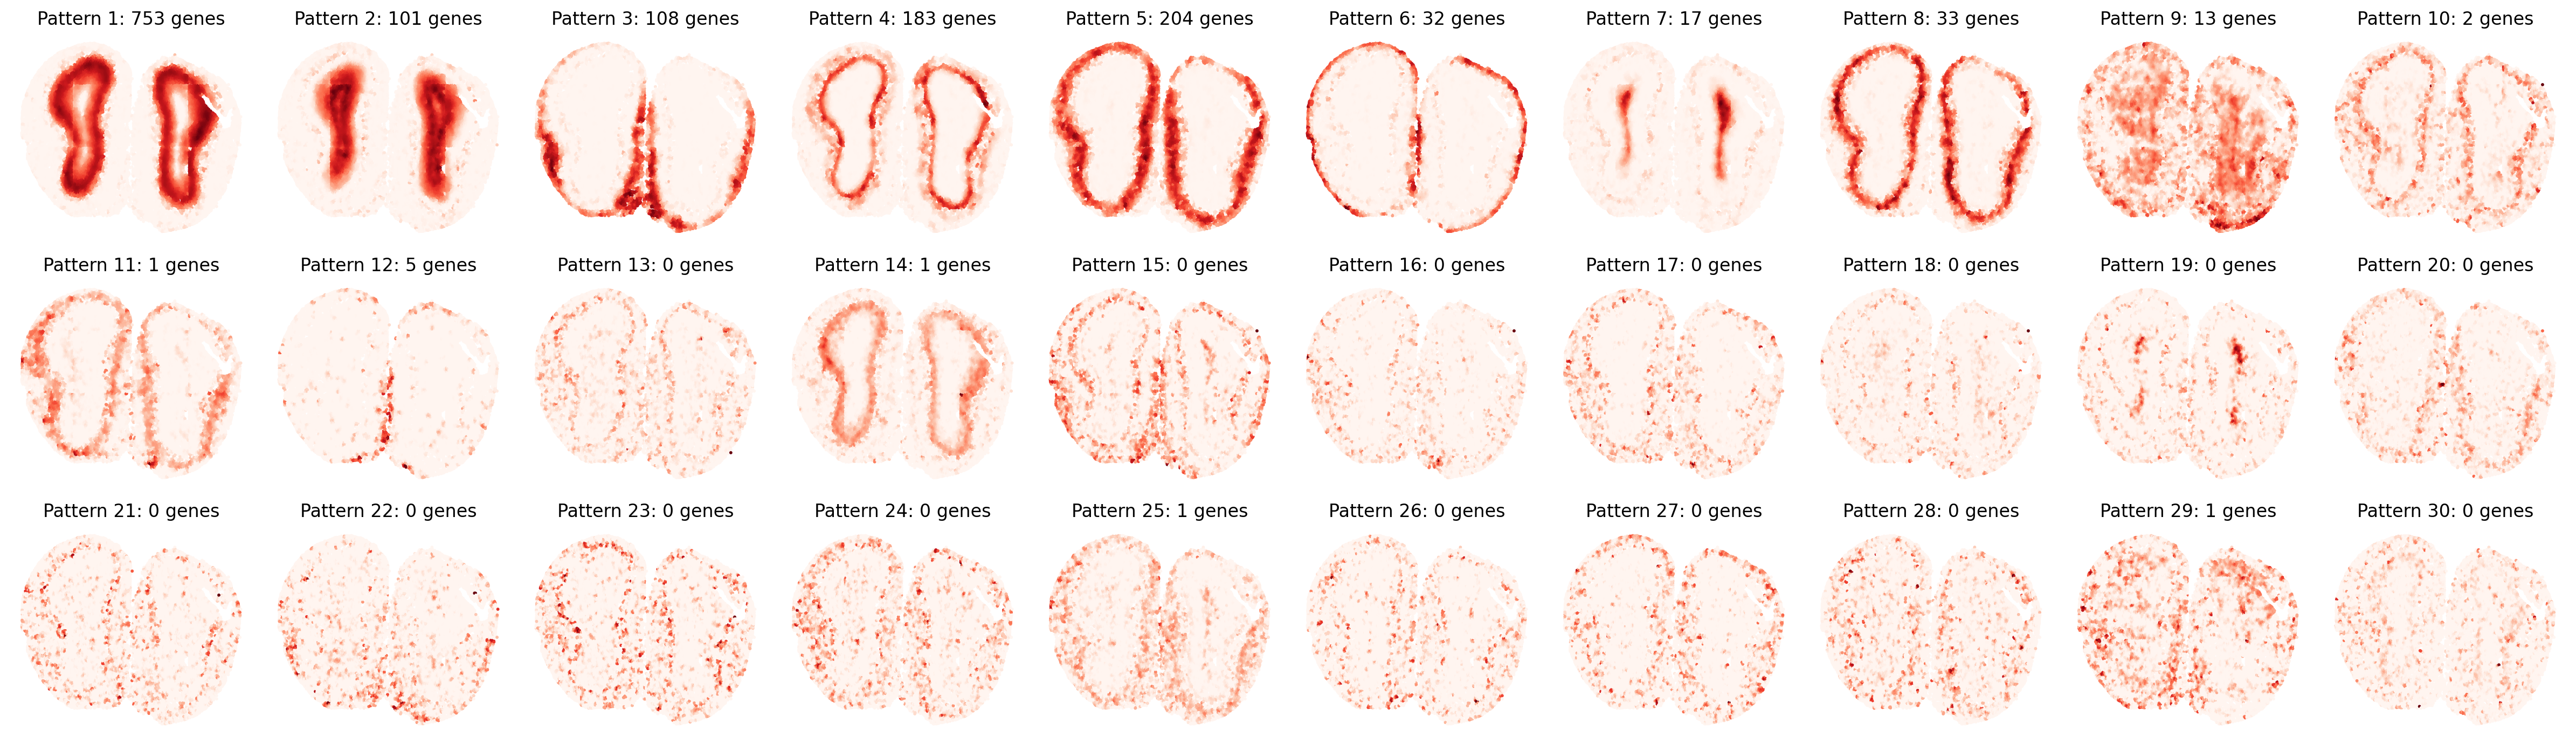

In [6]:
# Visualize all spatial patterns
sim_slt = separ.sim_res(separ.Wpn, separ.Hpn, separ.Xt.T)
sim_argsort = np.argsort(-sim_slt)

num_patterns = 30
plt.figure(dpi=200, figsize=(24, 7))
for i in range(30):
    ii = sim_argsort[i]
    plt.subplot(3, np.int(num_patterns/3), i + 1)
    plt.scatter(separ.loc[:, 0], separ.loc[:, 1], 
                c=separ.Wpn[:, ii].reshape(-1, 1), 
                s=1.2, cmap='Reds')
    plt.axis('off')
    plt.title(f'Pattern {i + 1}: {int(separ.genes_per_pattern[ii])} genes', 
              fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
# Create and display sorted pattern-specific genes table  
print("\nTop Pattern-Specific Genes (Sorted by Pattern Significance):")  
print("-" * 100)  
print(f"{'Pattern':11} | {'Significance':11} | {'#Genes':8} | {'Top Genes'}")  
print("-" * 100)  

for rank, pattern_idx in enumerate(sim_argsort[:30]):  
    genes = pattern_genes[pattern_idx]  
    if len(genes) == 0:  
        gene_str = "None"  
    else:  
        gene_str = ", ".join(genes[:10])  
        if len(genes) > 10:  
            gene_str += "..."  
    
    print(f"Pattern {rank+1:<3} | {sim_slt[pattern_idx]:.4f}      | {len(genes):<8} | {gene_str}")  
print("-" * 100)  


Top Pattern-Specific Genes (Sorted by Pattern Significance):
----------------------------------------------------------------------------------------------------
Pattern     | Significance | #Genes   | Top Genes
----------------------------------------------------------------------------------------------------
Pattern 1   | 0.9338      | 753      | Npas4, Cpne6, Necab3, Egr4, Slc35d3, Hpcal4, Shisa8, Cdkn1a, Fam126a, Dusp14...
Pattern 2   | 0.8867      | 101      | Nrgn, Cartpt, Ctxn3, Prkcg, Dll1, C130073E24Rik, Camk4, Lamp5, Necab2, Gm45341...
Pattern 3   | 0.8674      | 108      | Clca3a1, Agt, Cebpd, Serpina3n, Gm34838, Matn4, Omp, S100a5, Kctd12, Hmgcs2...
Pattern 4   | 0.8625      | 183      | Shisa3, Lbhd2, Kcnk15, Nefm, Nefh, Spp1, Npr1, Tbx21, Lrrtm1, Nrn1...
Pattern 5   | 0.8586      | 204      | Nppa, Trh, AI593442, Cnr1, Calb1, Insm1, Gm11549, Gpx3, Fibcd1, Syndig1l...
Pattern 6   | 0.7912      | 32       | Fmod, Ogn, Nov, Slc6a20a, Slc13a4, Igf2, Mgp, Slc6a13, Col1a2, Ae

## 3. Spatially Variable Genes (SVGs) Analysis

In [8]:
# Get SVG results  
svg_results = separ.recognize_svgs(err_tol=0.7)

Visualize some top and bottom SVGs:

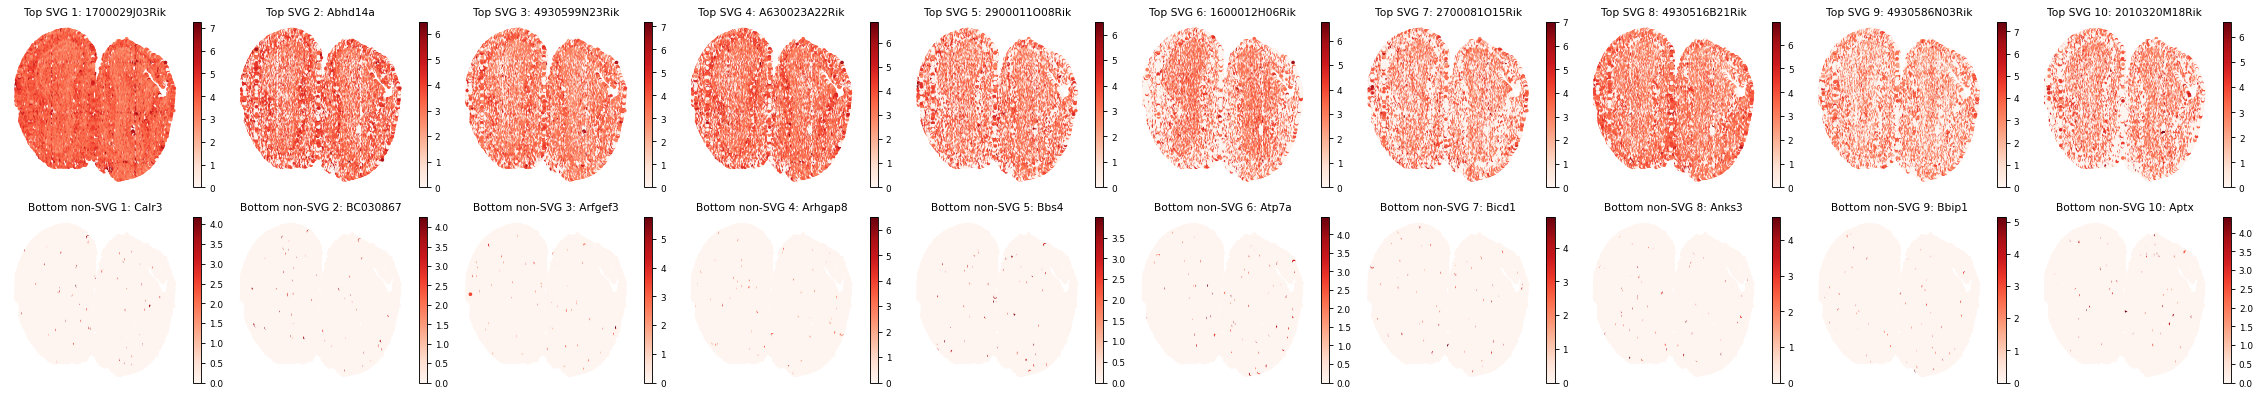

In [9]:
gene_ranking = svg_results['gene_ranking']
# Create a single figure with subplots for top SVGs and bottom non-SVGs  
plt.figure(figsize=(8.5/3*10, 5), dpi=80)  
plt.rcParams['font.size'] = 8  
# Plot top 10 SVGs  
for i in range(10):  
    plt.subplot(2, 10, i+1)  
    gene_idx = gene_ranking[i]  
    gene_name = adata.var_names[gene_idx]  
    gene_exp = separ.adata[:, gene_idx].X.toarray().flatten()  
    
    scatter = plt.scatter(separ.adata.obsm['spatial'][:, 0],   
                        separ.adata.obsm['spatial'][:, 1],  
                        c=gene_exp, s=5, cmap='Reds')  
    plt.title(f'Top SVG {i+1}: {gene_name}')  
    plt.axis('off')  
    plt.colorbar(scatter)  

# Plot bottom 10 non-SVGs  
for i in range(10):  
    plt.subplot(2, 10, i+11)  
    gene_idx = gene_ranking[-(i+1)]  
    gene_name = adata.var_names[gene_idx]  
    gene_exp = separ.adata[:, gene_idx].X.toarray().flatten()  
    
    scatter = plt.scatter(separ.adata.obsm['spatial'][:, 0],   
                        separ.adata.obsm['spatial'][:, 1],  
                        c=gene_exp, s=5, cmap='Reds')  
    plt.title(f'Bottom non-SVG {i+1}: {gene_name}')  
    plt.axis('off')  
    plt.colorbar(scatter)  

plt.tight_layout()  
plt.show()

## 4. Gene Expression Refinement

In [10]:
adata_refined = separ.get_refined_expression()

### Evaluating Refinement Performance  

First, we use Moran's I statistic to quantitatively evaluate the improvement in spatial patterns. Moran's I measures spatial autocorrelation, with higher values indicating stronger spatial patterns. The violin plot below compares the distribution of Moran's I values between raw and refined expression data across all genes: 

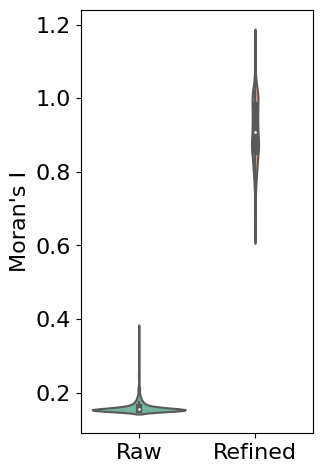

In [11]:
# Calculate Moran's I for both raw and refined data  
morani = sc.metrics.morans_i(separ.adata)  
morani_refine = sc.metrics.morans_i(adata_refined)  

# Create DataFrame for violin plot  
data_violin = pd.DataFrame({  
    'Moran\'s I': np.concatenate([morani, morani_refine]),  
    'Condition': ['Raw'] * len(morani) + ['Refined'] * len(morani_refine)  
})  

import seaborn as sns
# Create violin plot  
plt.rcParams['font.size'] = 16  
plt.figure(figsize=(3, 5.5))  
sns.violinplot(x='Condition', y='Moran\'s I', data=data_violin, palette='Set2')  
plt.ylabel('Moran\'s I')  
plt.xlabel('')  
plt.show()  

### Single Gene Visualization

To demonstrate the refinement effect at individual gene level, we visualize the spatial expression pattern of a single gene. The comparison shows how SEPAR preserves and enhances genuine spatial patterns while reducing technical noise:

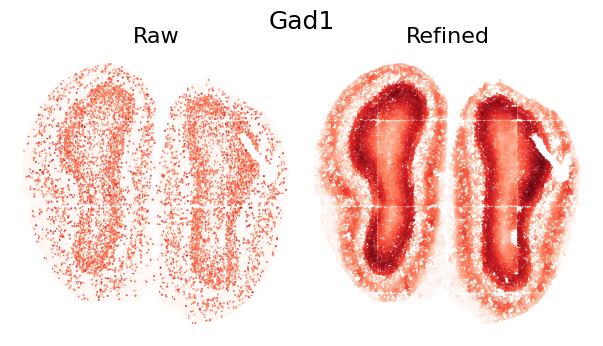

In [12]:
def plot_gene_refinement(gene_name, separ, adata_refined):  
    """  
    Visualize raw and refined expression patterns for a specific gene.  
    
    Parameters  
    ----------  
    gene_name : str  
        Name of the gene to visualize  
    separ : SEPAR object  
        SEPAR object containing raw data  
    adata_refined : AnnData  
        Refined expression data from get_refined_expression()  
    """  
    # Get gene index and expression values  
    gene_idx = separ.adata.var_names.get_loc(gene_name)  
    raw_exp = separ.adata[:, gene_idx].X.toarray().flatten()  
    refined_exp = adata_refined.X[:, gene_idx]  

    # Create comparison plot  
    plt.rcParams['font.size'] = 16  
    plt.figure(dpi=100, figsize=(7/1.2, 4/1.2))  
    
    # Set main title  
    plt.suptitle(gene_name, fontsize=18)  
    
    # Plot raw expression  
    plt.subplot(1, 2, 1)  
    plt.scatter(separ.loc[:, 0], separ.loc[:, 1],  
                c=raw_exp, s=0.3, cmap='Reds', rasterized=True)  
    plt.axis('off')  
    plt.title('Raw', fontsize=16)  
    
    # Plot refined expression  
    plt.subplot(1, 2, 2)  
    plt.scatter(separ.loc[:, 0], separ.loc[:, 1],  
                c=refined_exp, s=0.3, cmap='Reds', rasterized=True)  
    plt.axis('off')  
    plt.title('Refined', fontsize=16)  
    
    plt.tight_layout(pad=0)  
    plt.show()  

plot_gene_refinement("Gad1", separ, adata_refined)

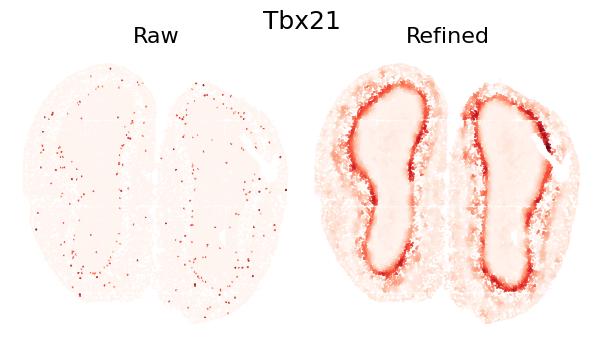

In [13]:
plot_gene_refinement("Tbx21", separ, adata_refined) 

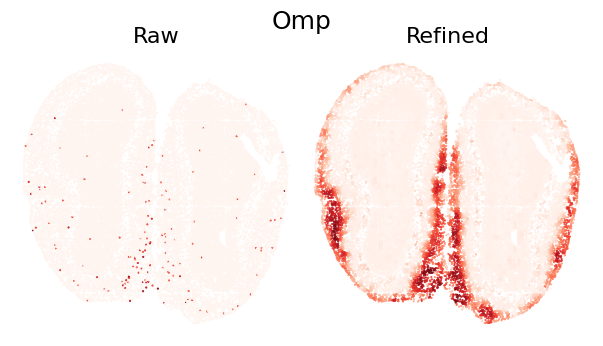

In [14]:
plot_gene_refinement("Omp", separ, adata_refined) 

## 5. Performing Clustering

In [15]:
# Perform clustering
cluster_res = separ.clustering(n_cluster=10, N1=16, N2=4)

### Clustering Results Visualization

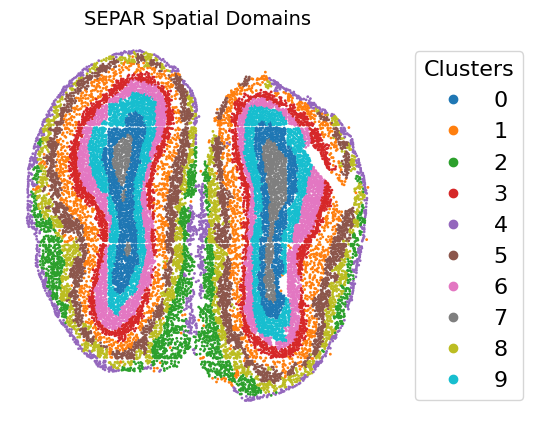

In [16]:
# Create visualization  
fig, ax = plt.subplots(figsize=(6, 5), dpi=100)  
scatter = ax.scatter(separ.loc[:, 0], separ.loc[:, 1],   
                    c=separ.labelres, s=1, cmap='tab10')  
plt.title("SEPAR Spatial Domains", fontsize=14)  
plt.axis('off')  

# Add legend  
legend = ax.legend(*scatter.legend_elements(),  
                  title="Clusters",  
                  bbox_to_anchor=(1.05, 0.5),  
                  loc='center left')  

plt.subplots_adjust(right=0.75)  
plt.show()  

## References  

[1] Dong, Kangning, and Shihua Zhang. “Deciphering spatial domains from spatially resolved transcriptomics with an adaptive graph attention auto-encoder.” Nature Communications 13.1 (2022): 1-12.